In [1]:
!pip3 install PyPDF2

     |████████████████████████████████| 81kB 4.1MB/s 
  Created wheel for PyPDF2: filename=PyPDF2-1.26.0-cp36-none-any.whl size=61086 sha256=bb20d59b93ff8308ca3e3ba660a7f57078dce571626a7b33bba9cbd352a58f9b
  Stored in directory: /root/.cache/pip/wheels/53/84/19/35bc977c8bf5f0c23a8a011aa958acd4da4bbd7a229315c1b7
Successfully built PyPDF2


In [2]:
import PyPDF2
import os
from os import listdir
from os.path import isfile, join
from io import StringIO
import pandas as pd
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()
from spacy.matcher import PhraseMatcher

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
resume_path = '/content/gdrive/My Drive/AI recruiter responses/resumes'
mypath = '/content/gdrive/My Drive/AI recruiter responses/'



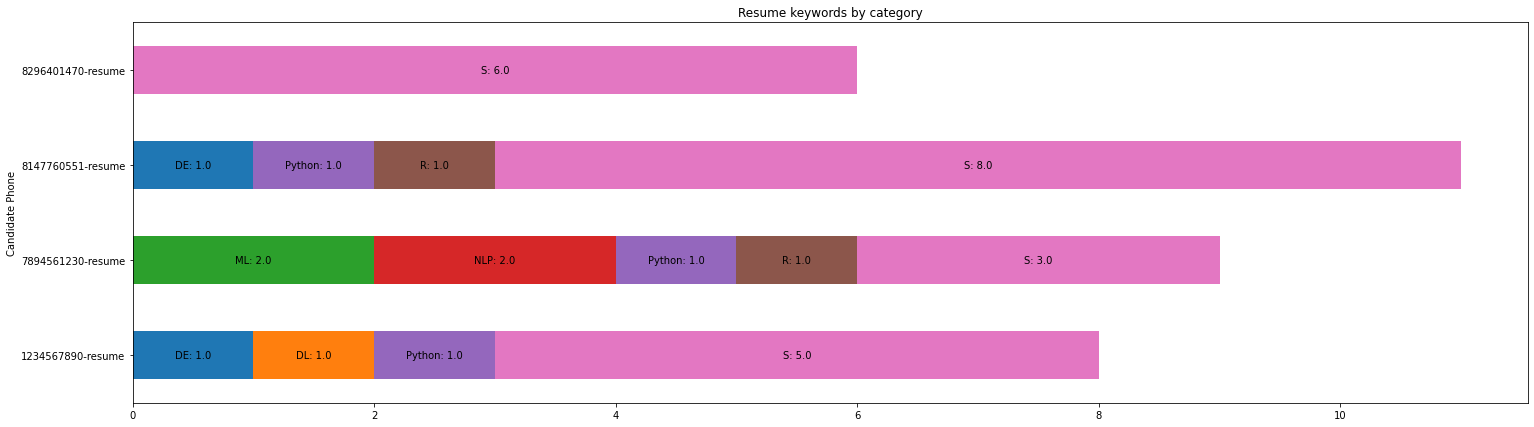

In [5]:
#resume_path='resumes' #enter your path here where you saved the resumes
onlyfiles = [os.path.join(resume_path, f) for f in os.listdir(resume_path) if os.path.isfile(os.path.join(resume_path, f))]

def pdfextract(file):
    fileReader = PyPDF2.PdfFileReader(open(file,'rb'))
    countpage = fileReader.getNumPages()
    count = 0
    text = []
    while count < countpage:    
        pageObj = fileReader.getPage(count)
        count +=1
        t = pageObj.extractText()
        text.append(t)
    return text

#function to convert all keywords in csv to lowercase
def convert_lowercase(file):
  df = pd.read_csv(file)
  df = df.apply(lambda x: x.astype(str).str.lower())
  df.to_csv(resume_path + '/../templates/keywords.csv',index=False)
  return 

#function to read resume ends


#function that does phrase matching and builds a candidate profile
def create_profile(file):
    text = pdfextract(file) 
    text = str(text)
    text = text.replace("\\n", " ")
    text = text.lower()
    convert_lowercase(resume_path + '/../templates/keywords.csv')
    #below is the csv where we have all the keywords, you can customize your own
    keyword_dict = pd.read_csv(resume_path + '/../templates/keywords.csv')
    stats_words = [nlp(text) for text in keyword_dict['Statistics'].dropna(axis = 0)]
    NLP_words = [nlp(text) for text in keyword_dict['NLP'].dropna(axis = 0)]
    ML_words = [nlp(text) for text in keyword_dict['Machine Learning'].dropna(axis = 0)]
    DL_words = [nlp(text) for text in keyword_dict['Deep Learning'].dropna(axis = 0)]
    R_words = [nlp(text) for text in keyword_dict['R Language'].dropna(axis = 0)]
    python_words = [nlp(text) for text in keyword_dict['Python Language'].dropna(axis = 0)]
    Data_Engineering_words = [nlp(text) for text in keyword_dict['Data Engineering'].dropna(axis = 0)]
    Software_words = [nlp(text) for text in keyword_dict['Software'].dropna(axis = 0)]

    matcher = PhraseMatcher(nlp.vocab)
    matcher.add('Stats', None, *stats_words)
    matcher.add('NLP', None, *NLP_words)
    matcher.add('ML', None, *ML_words)
    matcher.add('DL', None, *DL_words)
    matcher.add('R', None, *R_words)
    matcher.add('Python', None, *python_words)
    matcher.add('DE', None, *Data_Engineering_words)
    matcher.add('S', None, *Software_words)
    doc = nlp(text)
    
    d = []  
    matches = matcher(doc)
    for match_id, start, end in matches:
        rule_id = nlp.vocab.strings[match_id]  # get the unicode ID, i.e. 'COLOR'
        span = doc[start : end]  # get the matched slice of the doc
        d.append((rule_id, span.text))      
    keywords = "\n".join(f'{i[0]} {i[1]} ({j})' for i,j in Counter(d).items())
    
    ## convertimg string of keywords to dataframe
    df = pd.read_csv(StringIO(keywords),names = ['Keywords_List'])
    df1 = pd.DataFrame(df.Keywords_List.str.split(' ',1).tolist(),columns = ['Subject','Keyword'])
    df2 = pd.DataFrame(df1.Keyword.str.split('(',1).tolist(),columns = ['Keyword', 'Count'])
    df3 = pd.concat([df1['Subject'],df2['Keyword'], df2['Count']], axis =1) 
    df3['Count'] = df3['Count'].apply(lambda x: x.rstrip(")"))
    
    base = os.path.basename(file)
    filename = os.path.splitext(base)[0]
       
    name = filename.split('_')
    name2 = name[0]
    name2 = name2.lower()
    ## converting str to dataframe
    name3 = pd.read_csv(StringIO(name2),names = ['Candidate Phone'])
    
    dataf = pd.concat([name3['Candidate Phone'], df3['Subject'], df3['Keyword'], df3['Count']], axis = 1)
    dataf['Candidate Phone'].fillna(dataf['Candidate Phone'].iloc[0], inplace = True)

    return(dataf)
        
#function ends
        
#code to execute/call the above functions

final_database=pd.DataFrame()
i = 0 
while i < len(onlyfiles):
    file = onlyfiles[i]
    dat = create_profile(file)
    final_database = final_database.append(dat)
    i +=1

#code to count words under each category and visulaize it through Matplotlib

final_database2 = final_database['Keyword'].groupby([final_database['Candidate Phone'], final_database['Subject']]).count().unstack()
final_database2.reset_index(inplace = True)
final_database2.fillna(0,inplace=True)
new_data = final_database2.iloc[:,1:]
new_data.index = final_database2['Candidate Phone']
#execute the below line if you want to see the candidate profile in a csv format
#sample2=new_data.to_csv('sample.csv')
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
ax = new_data.plot.barh(title="Resume keywords by category", legend=False, figsize=(25,7), stacked=True)
labels = []
for j in new_data.columns:
    for i in new_data.index:
        label = str(j)+": " + str(new_data.loc[i][j])
        labels.append(label)
patches = ax.patches
for label, rect in zip(labels, patches):
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
        ax.text(x + width/2., y + height/2., label, ha='center', va='center')
plt.show()

In [6]:
 
final_database2['Score'] =final_database2.iloc[:,1:].sum(axis=1)

final_database2['Candidate Phone'] = final_database2['Candidate Phone'].str.replace(r'-resume','')
final_database2['Candidate Phone'] = final_database2['Candidate Phone'].astype(str)
#final_database2.sort_values('Candidate Phone',inplace= True)
print(final_database2)
type(final_database2['Candidate Phone'][0] )
final_database2['Candidate Phone']=final_database2['Candidate Phone'][:][:10]
sheet_df = pd.read_csv(mypath + 'resumes.csv')
sheet_df.sort_values('Phone Number',inplace=True)
sheet_df['Phone Number'] = sheet_df['Phone Number'].astype(str)
sheet_df['Score'] = 0

phones = dict(zip(final_database2['Candidate Phone'],final_database2['Score']))

for key in phones.keys():
 # print(sheet_df.loc[sheet_df['Phone Number'] == phone])
  sheet_df['Score'][sheet_df['Phone Number'] == key] = phones[key]
print(sheet_df)

sheet_df.sort_values('Score',ascending=False,inplace=True)
sheet_df.to_csv(mypath + 'resumes.csv',index=False)

Subject Candidate Phone   DE   DL   ML  NLP  Python    R    S  Score
0            1234567890  1.0  1.0  0.0  0.0     1.0  0.0  5.0    8.0
1            7894561230  0.0  0.0  2.0  2.0     1.0  1.0  3.0    9.0
2            8147760551  1.0  0.0  0.0  0.0     1.0  1.0  8.0   11.0
3            8296401470  0.0  0.0  0.0  0.0     0.0  0.0  6.0    6.0
            Timestamp                Email Address  ... Phone Number Score
2  6/29/2020 13:11:58    datavengersteam@gmail.com  ...   1234567890     8
4  6/29/2020 13:42:28    datavengersteam@gmail.com  ...   5874551612     0
5  6/29/2020 13:22:36      chetan.vm4070@gmail.com  ...   7353104070     0
6  6/29/2020 13:12:41   sudarshan.is17@rvce.edu.in  ...   7892345448     0
1  6/29/2020 13:12:57    datavengersteam@gmail.com  ...   7894561230     9
0  6/28/2020 11:24:04  raghavendragb1999@gmail.com  ...   8147760551    11
3  6/28/2020 11:23:31     venkateshr0711@gmail.com  ...   8296401470     6
7  6/28/2020 22:06:02     vaibhuchinnari@gmail.com  ...

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy [ipykernel_launcher.py:19]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy [ipykernel_launcher.py:19]


In [7]:
#emailing part

import getpass
import pandas as pd
import configparser

def sendEmail(emailid,pw,receivers):
  import smtplib
  from email.mime.multipart import MIMEMultipart
  from email.mime.text import MIMEText
  #mail_content = "Hello,This is a simple mail. There is only text, no attachments are there The mail is sent using Python SMTP library.Thank You"
  #The mail addresses and password
  sender_address = emailid
  sender_pass = pw



  for key in receivers.keys():

    #Setup the MIME
    message = MIMEMultipart()
    message['From'] = sender_address
    message['To'] = key
    message['Subject'] = 'Congratulations! from datavengers team'   #The subject line
    temp = key.split('@')
    temp = temp[0].split('.')
    #temp = temp[0].split(r'[0-9]+')
    
    user_name = receivers[key]
    mail_content = 'Hi, ' + user_name.upper() + '''\nGreetings from Data Vengers! \nCongrats! on being shortlisted for the next round of interview.\nYou will be initimated about the next interview schedule through another mail.'''
    #The body and the attachments for the mail
    message.attach(MIMEText(mail_content, 'plain'))
    #Create SMTP session for sending the mail
    session = smtplib.SMTP('smtp.gmail.com', 587) #use gmail with port
    session.starttls() #enable security
    session.login(sender_address, sender_pass) #login with mail_id and password
    text = message.as_string()
    session.sendmail(sender_address, key, text)
    session.quit()
  print('Mail Sent')



In [8]:
try: 
      global emailid
      emailid = "datavengersteam@gmail.com"
      global p
      config = configparser.ConfigParser()
      config.read(mypath + 'pw.ini')
      p = config['password']['pw']
      
except Exception as error: 
      print('%s', error) 

df = pd.read_csv(mypath + 'resumes.csv').head(5)
receivers = dict(zip(df['Email Address'],df['Name']))
#receivers = df['Email Address'].tolist()
sendEmail(emailid,p,receivers)

Mail Sent
